# Transit and Eclipse in the same dataset

In this notebook, we will demonstrate `juliet`'s capability of simultaneously fitting transit and eclipse in the same dataset.

- Data used: WASP-18, TESS Sector 2 (Data can be found in the 'Data' folder)
- Model: Transit and Eclipse model
- `juliet` version: `dev` version of `juliet` for which the pull request is opened ([this](https://github.com/Jayshil/juliet/tree/dev) version)

First of all, let us import necessary packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import juliet
import os
import matplotlib.gridspec as gd

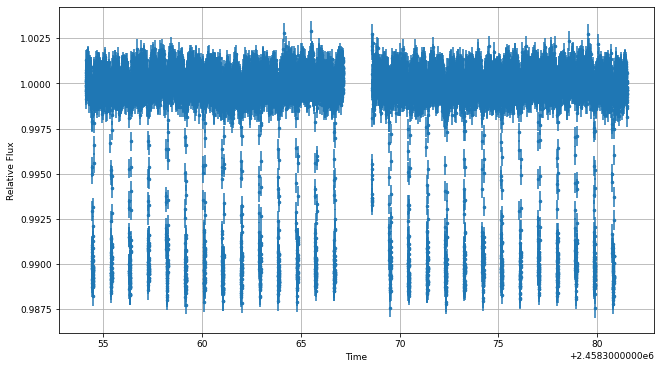

In [2]:
# Let's first load and visualise the data
tim1, fl1, fle1 = np.loadtxt(os.getcwd() + '/Data/WASP-18_TESS2.dat',\
    usecols=(0,1,2), unpack=True)

plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(tim1, fl1, yerr=fle1, fmt='.')
plt.xlabel('Time')
plt.ylabel('Relative Flux')
plt.grid()

The data looks nice! Transits of the planet is clearly visible.

In [3]:
# Converting data products in dictionary, so that juliet can understand it!
tim, fl, fle = {}, {}, {}
tim['TESS2'], fl['TESS2'], fle['TESS2'] = tim1, fl1, fle1

Since, we are interested in fitting transit and eclipse, we would,
- Include priors on eclipse depth, `fp`
- Include LDCs.
- Note that `p` and `fp` both are now planetary _and_ instrumental parameters. So, while providing priors, we will use `p_p1_TESS2` and `fp_p1_TESS2`. (Note that while analysing multiple instruments, we can share either `p_p1` or `fp_p1` or both over multiple instruments. See other notebooks for a demonstration.)
- Although `fp` is planetary _and_ instrumental parameter, the light travel correction factor is still _only_ planetary parameter, i.e., we will use `ac_p1`.

In [4]:
# Some planetary parameters (to provide priors)
# All parameters are taken from Cortés-Zuleta et al. 2020
per, per_err = 0.94145223, 0.00000024
bjd0, bjd0_err = 2456740.80560, 0.00019
ac1 = 0.0001169                        # Computed from a = 0.02024 AU and c
## Computing transit time for the epoch from the data
cycle = round((tim1[-1] - bjd0)/per)
tc1 = np.random.normal(bjd0, bjd0_err, 100000) + cycle*np.random.normal(per, per_err, 100000)
tc0, tc0_err = np.median(tc1), np.std(tc1)

# And priros (Note that p and fp are planetary and instrumental parameters):
par_P = ['P_p1', 't0_p1', 'p_p1_TESS2', 'b_p1', 'q1_TESS2', 'q2_TESS2',\
     'a_p1', 'fp_p1_TESS2', 'ac_p1', 'ecc_p1', 'omega_p1']
dist_P = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform',\
     'loguniform', 'uniform', 'fixed', 'fixed', 'fixed']
hyper_P = [[per, per_err], [tc0, 0.1], [0., 1.], [0., 1.], [0.,1.], [0.,1.],\
     [1., 10.], [0.e-6, 500.e-6], ac1, 0., 90.]

## Instrumental and GP parameters
par_ins = ['mdilution_TESS2', 'mflux_TESS2', 'sigma_w_TESS2']
dist_ins = ['fixed', 'normal', 'loguniform']
hyper_ins = [1., [0., 0.1], [0.1, 10000.]]

par_gp = ['GP_sigma_TESS2', 'GP_timescale_TESS2', 'GP_rho_TESS2']
dist_gp = ['loguniform', 'loguniform', 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

par_tot = par_P + par_ins + par_gp
dist_tot = dist_P + dist_ins + dist_gp
hyper_tot = hyper_P + hyper_ins + hyper_gp

priors_tot = juliet.utils.generate_priors(par_tot, dist_tot, hyper_tot)

In [5]:
# And fitting it!
dataset = juliet.load(priors=priors_tot, t_lc=tim, y_lc=fl, yerr_lc=fle,\
    GP_regressors_lc=tim, out_folder=os.getcwd() + '/Analysis/Transit-Eclipse')
res = dataset.fit(sampler = 'dynesty')

Detected dynesty sampler output files --- extracting from /Users/japa6985/Documents/Codes/juliet-examples/Analysis/Transit-Eclipse/_dynesty_NS_posteriors.pkl


In [6]:
os.system("cat Analysis/Transit-Eclipse/posteriors.dat")

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 0.9414522644 	 	 0.0000002404 	 	 0.0000002343
t0_p1              	 	 2458381.7600147524 	 	 0.0000346485 	 	 0.0000324165
p_p1_TESS2         	 	 0.0981715419 	 	 0.0004132988 	 	 0.0003892383
b_p1               	 	 0.4056095966 	 	 0.0211015360 	 	 0.0234722341
q1_TESS2           	 	 0.2066485039 	 	 0.0348081506 	 	 0.0307997720
q2_TESS2           	 	 0.3406377235 	 	 0.0751431473 	 	 0.0661029722
a_p1               	 	 3.4286750806 	 	 0.0304934883 	 	 0.0286869326
fp_p1_TESS2        	 	 0.0003635838 	 	 0.0000260352 	 	 0.0000254027
mflux_TESS2        	 	 0.0005657009 	 	 0.0045994566 	 	 0.0041406436
sigma_w_TESS2      	 	 1.3064306647 	 	 7.2733804307 	 	 1.0837491778
GP_sigma_TESS2     	 	 0.0000225919 	 	 0.0000425187 	 	 0.0000101731
GP_timescale_TESS2 	 	 0.0134858861 	 	 0.0112734724 	 	 0.0086582562
GP_rho_TESS2       	 	 60.3778212360 	 	 26.2190481196 	 	 24.9060863346


0

The posteriors look good for most of the planetary parameters and seems to agree with their corresponding values from the literature.

Let's now visualise our results to make sure that everything was smooth.

In [7]:
# juliet best fit model
model = res.lc.evaluate('TESS2')
gp_model = res.lc.model['TESS2']['GP']
transit_model = res.lc.model['TESS2']['deterministic']

(2458354.1115072616, 2458381.5174589776)

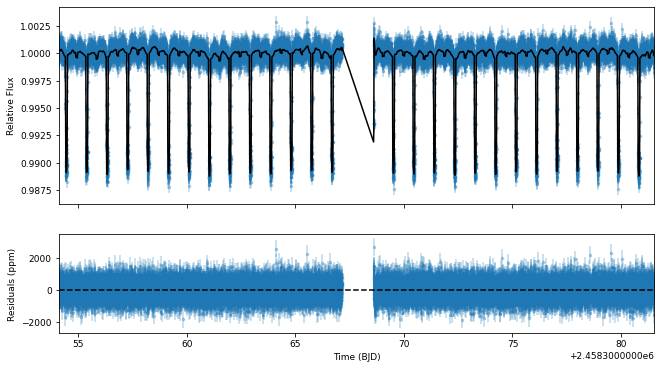

In [8]:
# Making a plot
fig = plt.figure(figsize=(16/1.5,9/1.5))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim['TESS2'], fl['TESS2'], yerr=fle['TESS2'], fmt='.', alpha=0.3)
ax1.plot(tim['TESS2'], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim['TESS2']), np.max(tim['TESS2']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim['TESS2'], (fl['TESS2']-model)*1e6, yerr=fle['TESS2']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim['TESS2']), np.max(tim['TESS2']))

This is good! Trends seem to be removed. And one can see the eclipse signal even by eye!

We can now make a phase-folded lightcurve to better visualise the results.

(-0.1, 0.6)

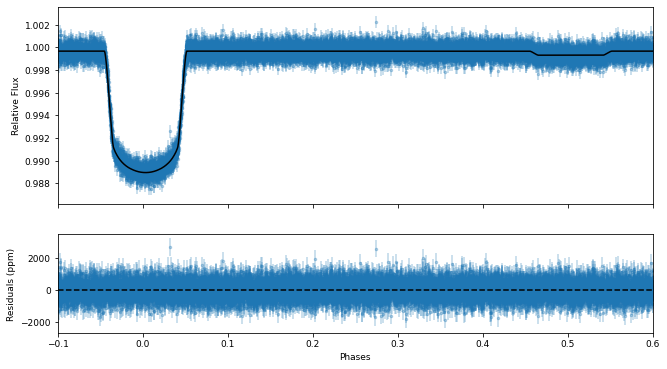

In [9]:
phs = juliet.utils.get_phases(tim['TESS2'], per, bjd0, phmin=0.8)
idx = np.argsort(phs)
# Making a plot
fig = plt.figure(figsize=(16/1.5,9/1.5))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(phs, fl['TESS2']-gp_model, yerr=fle['TESS2'], fmt='.', alpha=0.3)
ax1.plot(phs[idx], transit_model[idx], c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(-0.1, 0.6)
#ax1.set_ylim(0.998, 1.002)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(phs, (fl['TESS2']-model)*1e6, yerr=fle['TESS2']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--', zorder=100)
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Phases')
ax2.set_xlim(-0.1, 0.6)

This is fantastic!